# ATLeS - Descriptive Statistics

This script is designed to provide a general purpose tool for producing descriptive statistics and visualizations for ATLES data. 

## Instructions
Provide experiment details in the 'Parameters' section below, then execute script to generate stats.

## General Information
Everytime an experiment is run ATLeS generates three files. 
1. date-time-experimentname.txt (log of tracking activity/issues)
2. date-time-experimentname-setup.txt (details of experimental setup)
3. date-time-experimentname-track.csv (track files; raw tracking data)





# Import Libraries

In [1]:
from pathlib import Path
import configparser
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

# add src/ directory to path to import ATLeS code
import os
import sys
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

# imported from ATLeS
from analysis.process import TrackProcessor
from analysis.plot import TrackPlotter

# displays plots in notbook output
%matplotlib inline 

## Parameters
Input experiment details here

In [2]:
experimentname = 'ACTEST2'
trackdirectory = '../data'
acquisitionlevel = .85  # sets the cut off level of excluding tracks based on poor tracking

## Identify the Data Files


In [3]:
# finds track and settingsfiles within the trackdirectory that match the experiment names
# and creates lists

trackfiles = list(Path(trackdirectory).glob(f'**/*{experimentname}*track.csv'))
settingsfiles = list(Path(trackdirectory).glob(f'**/*{experimentname}*setup.txt'))
    
print(f'{len(trackfiles)} track files were found with the name {experimentname}')
print(f'{len(settingsfiles)} settings files were found with the name {experimentname}\n')

if len(trackfiles) != len(settingsfiles):
    print('Warning: Mismatched data and settings files.')

61 track files were found with the name ACTEST2
61 settings files were found with the name ACTEST2



## Identify and Store Experimental Settings
The number of experimental phases varies across experiments. This block identifies the phases used for the current experiment and verfies that all tracks have the same phase information.
The settings may vary between tracks within an experiment. This block also identifies the settings for each track and writes them to a dictionary.

In [4]:
Config = configparser.ConfigParser()

settingsdic ={} #used to store results of this block
phaselist = [] #used later to verify phases are consistent across tracks


# reads and organizes information from each settings file
for file in settingsfiles:
    Config.read(file)
    
    # generate clean list of stimuli
    stiminfo = Config.get('experiment', 'stimulus') #gets stim info
    stiminfo = stiminfo.replace('(', ',').replace(')', '').replace(' ', '').split(',')[1:] #cleans phase list
    
    # generate clean list of phases
    phaselisttemp = Config.get('phases', 'phases_argstrings') # gets phase info
    phaselisttemp = phaselisttemp.replace('-p ', '').replace(' ', '').split(',')[:-1] #cleans phase list

    # compare each phase list with the list from the previous settings file
    if len(phaselist) == 0:
        phaselist = phaselisttemp
    elif phaselist != phaselisttemp:
        print('Warning: Inconsistent phases between settings files.')
    else:
        pass

    # counts phases and generates phase variable names
    phasenumber = len(phaselist)//2
    phasenames = []
    for i in range(phasenumber):
        p, t, s = 'phase', 'time', 'stim'
        phase = p+str(i+1)
        phasetime = phase + t
        phasestim = phase + s
        phasenames.extend((phasetime, phasestim))

    # gets settings info from file name (track/box)
    trackname = file.parts[-1].replace("-setup.txt", "")
    box = file.parts[-2]

    # gets settings info from setting file
    controller = Config.get('experiment', 'controller')
    trigger = Config.get('experiment', 'trigger')

    settings = [phaselisttemp, controller, trigger, stiminfo, box, str(file)]
    
    # puts all settings in dic keyed to trackname
    settingsdic[trackname] = settings

# creates settings dataframe from settingsdic
dfsettings = pd.DataFrame(settingsdic).transpose()
dfsettings.columns = ['phases', 'controller', 'trigger', 'stimulus', 'box', 'file']
dfsettings['track'] = dfsettings.index

# creates stimulus dataframe splits up and names stims
dfstim = pd.DataFrame(dfsettings.stimulus.values.tolist(), index=dfsettings.index).fillna('-')

for col in range(dfstim.shape[1]):
    dfstim=dfstim.rename(columns = {col:('stim_setting' + str(col))})


dfsettings.head(3)

,phases,controller,trigger,stimulus,box,file,track
20180118-160406-ACTEST2,"[5, off, 5, on, 10, off]",controllers.FixedRatioController(response_step=1),xpos > 0.50,"[ac_freq_Hz=20, active_freq_Hz=1, duty_cycle=0...",bbox1,../data/tracks/bbox1/20180118-160406-ACTEST2-s...,20180118-160406-ACTEST2
20180118-160741-ACTEST2,"[5, off, 5, on, 10, off]",controllers.FixedRatioController(response_step=1),xpos > 0.50,"[ac_freq_Hz=20, active_freq_Hz=1, duty_cycle=0...",bbox1,../data/tracks/bbox1/20180118-160741-ACTEST2-s...,20180118-160741-ACTEST2
20180122-160935-ACTEST2,"[5, off, 5, on, 10, off]",controllers.FixedRatioController(response_step=1),xpos > 0.50,"[ac_freq_Hz=20, active_freq_Hz=1, duty_cycle=0...",bbox1,../data/tracks/bbox1/20180122-160935-ACTEST2-s...,20180122-160935-ACTEST2


## Identify Phasetimes and Create Phase Dataframe

In [5]:
# Identify Phasetimes: extract phase info from settings w. trackname and calc phasetimes
# this currently assummes all phase time are the same across tracks
phaseinfo = settingsdic.get(trackname)[0]
phaseinfo = [x for x in phaseinfo if any(c.isdigit() for c in x)]
phaseinfo = list(map(int, phaseinfo))
phaseinfo = [i * 60 for i in phaseinfo]
phaselen = len(phaseinfo)

phaset = []
for i in range(phaselen):
    times = sum(phaseinfo[0:i+1])
    phaset.append(times)

a = 0
phaset[0:0] = [a]

phasedic = {}
for i in range(phaselen):
    phasedic[i+1] = [phaset[i], phaset[i+1]]


# splits up and names the phases
dfphase = pd.DataFrame(dfsettings.phases.values.tolist(), index=dfsettings.index).fillna('-')
dfphase.columns = phasenames

phasenum = len(dfphase.columns)//2 # figure out what this is for.... 

dfphase.head(3)


,phase1time,phase1stim,phase2time,phase2stim,phase3time,phase3stim
20180118-160406-ACTEST2,5,off,5,on,10,off
20180118-160741-ACTEST2,5,off,5,on,10,off
20180122-160935-ACTEST2,5,off,5,on,10,off


In [6]:
dfsettings.loc["20180118-160406-ACTEST2"].trigger

'xpos > 0.50'

## Function: Basic Descriptive Statistics for Tracks, Split by Phases
This is a function that produces basic statistics for each track. Function is reused to generate stats overall and stats for each phase. 

In [7]:
def get_basicstats(trackfilelist, settingsdic):

    # creates dictionary for storing stats, adds stats from individual tracks
    statsdic = {}
    for track in trackfilelist:
        # gets track from file name
        trackname = track.parts[-1]
        trackname = trackname.replace("-track.csv", "")

        # creates phasetime cutoffs to reduce df to phase selection
        phasetimes = phasedic    #to do: clean this up

        if phase == 0:
            ptimemin = min(min(phasetimes.values()))
            ptimemax = max(max(phasetimes.values()))
            pprefix = 'all_'
        else:
            ptimemin = phasetimes[phase][0]
            ptimemax = phasetimes[phase][1]
            pprefix = 'p{0}_'.format(phase)

        # creates dataframe from track
        trackdf = pd.read_csv(track, sep=",", quotechar='"', header=None)
        trackdf.columns = ['time', 'acquired', 'x', 'y', 'unknown1', 'unknown2', 'unknown3']
        
        if dfsettings.loc[trackname].trigger == 'xpos > 0.50': 
            trackdf['x'] = abs(trackdf['x'] - 1)
        
        # calculate some basic stats before the slice
        trackdf['xdif'] = trackdf['x'].diff().fillna(0).abs()
        trackdf['ydif'] = trackdf['y'].diff().fillna(0).abs()
        trackdf['xydif'] = trackdf['xdif'] + trackdf['ydif']
        trackdf['timedif'] = trackdf['time'].diff().fillna(0).abs()
        trackdf['speed'] = trackdf['xydif'] / trackdf['timedif']

        # slices df by phase
        trackdf = trackdf[trackdf['time'].between(ptimemin, ptimemax, inclusive=True)]

        # calculate basic stats
        timemax = trackdf.time.max()
        timemin = trackdf.time.min()
        
        acquiredmissinglost = trackdf['acquired'].value_counts(normalize=True, dropna=True)
        acquired = acquiredmissinglost.get('acquired', default=0)
        
        xmax = trackdf['x'].max()
        xmin = trackdf['x'].min()
        xavg = trackdf['x'].mean()
        xstd = trackdf['x'].std()
        xdifavg = trackdf['xdif'].mean()
        
        ymax = trackdf['y'].max()
        ymin = trackdf['y'].min()
        yavg = trackdf['y'].mean()
        ystd = trackdf['y'].std()
        ydifavg = trackdf['ydif'].mean()
        
        xydifavg = trackdf['xydif'].mean()
        speedavg = trackdf['speed'].mean()

        # create list of stats and list of statsnames
        bsvarlist = [timemax, timemin, acquired,
                     xmax, xmin, xavg, xdifavg, xstd,
                     ymax, ymin, yavg, ydifavg, ystd,
                     xydifavg, speedavg]
        bsvarnames = ['timemax', 'timemin', 'acquired',
                      'xmax', 'xmin', 'xavg', 'xdifavg', 'xstd',
                      'ymax', 'ymin', 'yavg', 'ydifavg', 'ystd',
                      'xydifavg', 'speedavg']

        # puts all settings in dic keyed to trackname
        statsdic[trackname] = bsvarlist

    # creates and names the settings dataframes from statsdic
    dfbasicstats = pd.DataFrame(statsdic).transpose()
    dfbasicstats.columns = bsvarnames
    dfbasicstats = dfbasicstats.add_prefix(pprefix)
    return dfbasicstats




## Combine Dataframes
Combines settings, stim, phase, and with aa dataframe of basic descriptive stats


In [8]:
df = dfsettings.join(dfphase).join(dfstim)  # joins settings, stim, and phase dataframes
df = df.drop(['phases', 'stimulus'], axis=1)  # drops unnecessary columns

# calculate basic descriptive stats for each track. Does this for each phase and for all phases combined (all)
for phase in range(phasenum + 1):
    print('Phase {0} processing...'.format(phase))
    dfstats = get_basicstats(trackfiles, settingsdic)
    df = df.join(dfstats)

print('Processing complete.')

Phase 0 processing...
Phase 1 processing...
Phase 2 processing...
Phase 3 processing...
Processing complete.


## Cleaning: Dataframe Characteristics

In [9]:
df.dropna(axis=0, how='all', inplace=True) # drops any rows where all values are missing

print(f'Dataframe Shape:{df.shape}')
print()      

print('Column Names:')
print(*list(df.columns.values), sep = ', ')
print()

print('Tracks with missing data (first five only):')
print(df[df.isnull().any(axis=1)][df.columns[df.isnull().any()]].head(5))
print()

for dt in df.dtypes.unique():
    print(f'Data Type, {dt}:')
    print(*list(df.select_dtypes(include=[dt]).columns), sep = ', ')
    print()

Dataframe Shape:(61, 75)

Column Names:
controller, trigger, box, file, track, phase1time, phase1stim, phase2time, phase2stim, phase3time, phase3stim, stim_setting0, stim_setting1, stim_setting2, stim_setting3, all_timemax, all_timemin, all_acquired, all_xmax, all_xmin, all_xavg, all_xdifavg, all_xstd, all_ymax, all_ymin, all_yavg, all_ydifavg, all_ystd, all_xydifavg, all_speedavg, p1_timemax, p1_timemin, p1_acquired, p1_xmax, p1_xmin, p1_xavg, p1_xdifavg, p1_xstd, p1_ymax, p1_ymin, p1_yavg, p1_ydifavg, p1_ystd, p1_xydifavg, p1_speedavg, p2_timemax, p2_timemin, p2_acquired, p2_xmax, p2_xmin, p2_xavg, p2_xdifavg, p2_xstd, p2_ymax, p2_ymin, p2_yavg, p2_ydifavg, p2_ystd, p2_xydifavg, p2_speedavg, p3_timemax, p3_timemin, p3_acquired, p3_xmax, p3_xmin, p3_xavg, p3_xdifavg, p3_xstd, p3_ymax, p3_ymin, p3_yavg, p3_ydifavg, p3_ystd, p3_xydifavg, p3_speedavg

Tracks with missing data (first five only):
                         p2_timemax  p2_timemin  p2_xmax  p2_xmin  p2_xavg  \
20180118-160406-

## Cleaning: Identifying Tracks that Terminated Early or had Poor Tracking


Track Times: Mean 1160.1375557377046, Minimum 15.408500000000002, Maximum 1198.9441, Count 61
Acquired: Mean 0.9781961528912654, Minimum 0.19181052456008674, Maximum 1.0, Count 61


,count,mean,std,min,25%,50%,75%,max
box,,,,,,,,
bbox1,18.0,0.998666,0.001056,0.995830,0.998248,0.998749,0.999312,1.000000
bbox2,15.0,0.995819,0.007598,0.972896,0.996789,0.999249,0.999583,1.000000
bbox3,8.0,0.996299,0.006350,0.982070,0.997372,0.999291,0.999500,0.999750
bbox4,6.0,0.996914,0.002773,0.994079,0.994431,0.996747,0.999374,1.000000
bbox5,14.0,0.914631,0.215640,0.191811,0.958177,0.998499,0.999333,0.999917


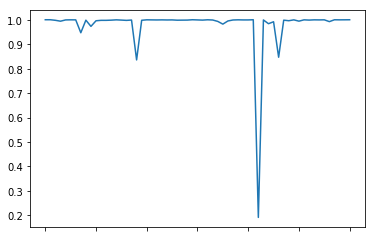

In [10]:
df['all_totaltime'] = df['all_timemax'] - df['all_timemin']
print(f'Track Times: Mean {df.all_totaltime.mean()}, Minimum {df.all_totaltime.min()}, Maximum {df.all_totaltime.max()}, Count {df.all_totaltime.count()}')
print(f'Acquired: Mean {df.all_acquired.mean()}, Minimum {df.all_acquired.min()}, Maximum {df.all_acquired.max()}, Count {df.all_acquired.count()}')

df.all_acquired.plot()

df['all_acquired'].groupby(df.box).describe()

## Cleaning: Removing Tracks that Terminated Early or had Poor Tracking
Need to work on something a bit less indiscriminate for initial removal.

In [11]:
print(f'Raw Track Number: {df.shape[0]}')
df.dropna(axis=0, how='any', inplace=True) # drops rows if any data is missing, this will remove early termination tracks
print(f'Modified Track Number: {df.shape[0]} (following removal for early termination of experiment)')
df = df.drop(df[df.all_acquired < acquisitionlevel].index)
print(f'Modified Track Number: {df.shape[0]} (following removal for poor tracking set at less than {acquisitionlevel}% acquired)')

df['all_acquired'].groupby(df.box).describe()

Raw Track Number: 61
Modified Track Number: 59 (following removal for early termination of experiment)
Modified Track Number: 56 (following removal for poor tracking set at less than 0.85% acquired)


,count,mean,std,min,25%,50%,75%,max
box,,,,,,,,
bbox1,16.0,0.998499,0.000999,0.995830,0.998144,0.998582,0.999187,0.999833
bbox2,15.0,0.995819,0.007598,0.972896,0.996789,0.999249,0.999583,1.000000
bbox3,8.0,0.996299,0.006350,0.982070,0.997372,0.999291,0.999500,0.999750
bbox4,6.0,0.996914,0.002773,0.994079,0.994431,0.996747,0.999374,1.000000
bbox5,11.0,0.993685,0.015697,0.946793,0.997998,0.998999,0.999500,0.999917


## Cleaning: Checking Randomization of Trigger Condition

In [12]:
print(f'Trigger Conditions: {df.trigger.unique()}')
print()

from scipy.stats import ttest_ind

# performs welch's t-test (does not assume equal variances) on all floats and prints any that are signficantly different as a function of trigger
for i in df.select_dtypes(include=['float64']).columns:
    ttest_result = ttest_ind(df[df.trigger == df.trigger.unique()[0]][i], df[df.trigger == df.trigger.unique()[1]][i], equal_var=False)
    if ttest_result.pvalue < .05:
        print(f'Welchs T-Test shows {i} is significantly different as a function of trigger condition, p = {ttest_result.pvalue}')
        print(f'{i} Trigger Condition 1 Mean: {df[df.trigger == df.trigger.unique()[0]][i].mean()}')
        print(f'{i} Trigger Condition 2 Mean: {df[df.trigger == df.trigger.unique()[1]][i].mean()}')
        print()

Trigger Conditions: ['xpos > 0.50' 'xpos < 0.50']

Welchs T-Test shows p1_acquired is significantly different as a function of trigger condition, p = 0.026143560853914154
p1_acquired Trigger Condition 1 Mean: 0.9996307026852724
p1_acquired Trigger Condition 2 Mean: 0.9978817868608916



In [13]:
i = 'p3_xavg'

temp2 = ttest_ind(df[df.trigger == df.trigger.unique()[0]][i], df[df.trigger == df.trigger.unique()[1]][i], equal_var=False)

temp2.pvalue

0.4565766643811371

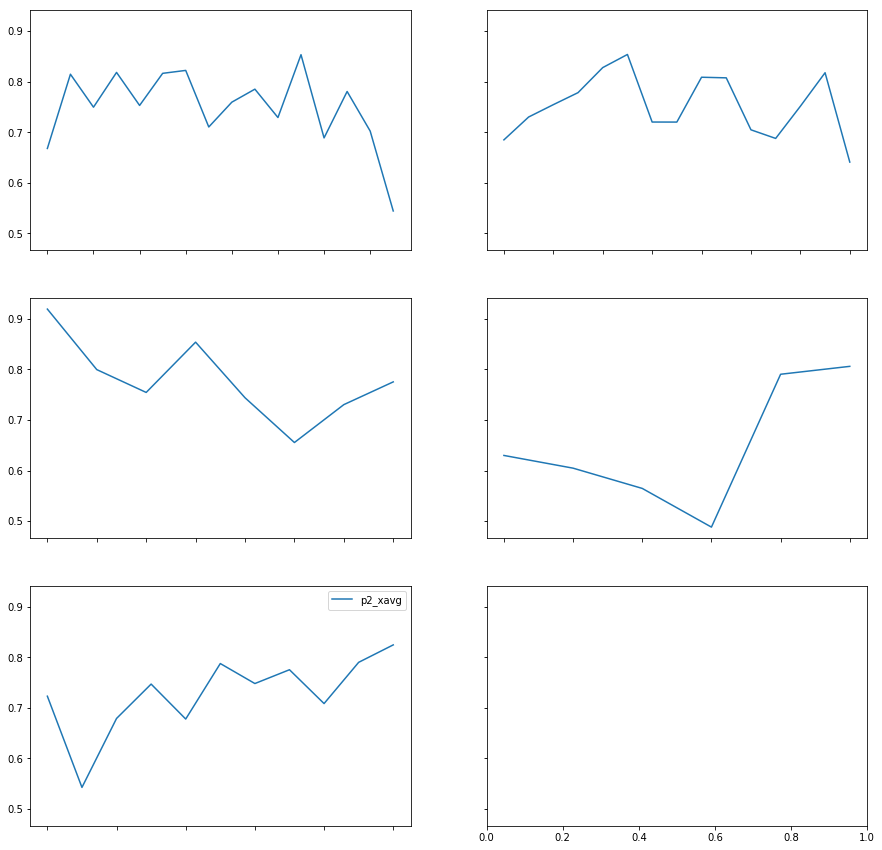

In [14]:
grouped = df['p2_xavg'].groupby(df.box)

ncols=2
nrows = int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15), sharey=True)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot(ax=ax)

ax.legend()
plt.show()

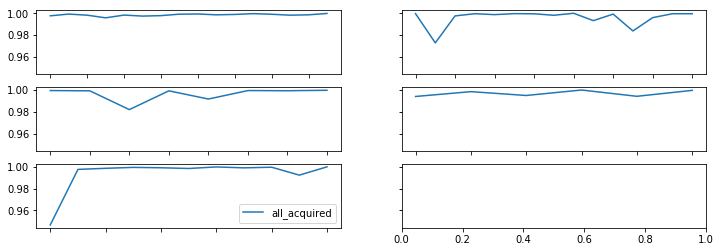

In [15]:
# df['all_acquired'].groupby(df.box).describe()
# df['all_acquired'].groupby(df.box).hist()
import numpy as np

grouped = df['all_acquired'].groupby(df.box)

ncols=2
nrows = int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,4), sharey=True)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot(ax=ax)

ax.legend()
plt.show()

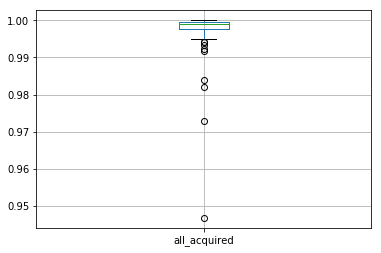

In [16]:
#fig = plt.gcf()
#fig.set_size_inches(18.5,10.5)
#df['all_acquired'].boxplot(ax=ax)
#plot.show()
df.boxplot(column='all_acquired')
plt.show()

In [17]:
# from pathlib import Path
# datadir = Path("C:\\Users\\User11\\Google Drive\\R-Zf-P00-Atles\\Atles-Track Data")
# print(datadir)

# files = datadir.glob("**/*.decoded")
# print(files)


# processors = [TrackProcessor(f) for f in files]

# #stats = [proc.get_stats() for proc in processors]
# stats = []
# for proc in processors:
#         stats.append(proc.get_stats())
        

In [18]:
processor = TrackProcessor(str(trackfiles[0]))
processor.get_stats(include_phases=True)

{'#Datapoints': 11989,
 '#Valid': 11978,
 '%Valid datapoints': 0.9990824922845942,
 'Total time (sec)': 1200.0399,
 'Valid time (sec)': 1197.943,
 'Total distance traveled (?)': 253.3700856220046,
 'Avg. x coordinate': 0.5465998497244949,
 'Avg. y coordinate': 0.2207663215895809,
 'Avg. speed (?/sec)': 0.21150429162489753,
 'Avg. x speed (?/sec)': 0.17818543954094646,
 'Avg. y speed (?/sec)': 0.07968492657830965,
 '#Triggers': 164,
 'Total time triggered (sec)': 422.16880000000015,
 'Avg. time per trigger (sec)': 2.5742000000000007,
 'Trigger frequency (per min)': 8.214080302652128,
 '#Freezes': 4,
 'Total time frozen (sec)': 157.58839999999998,
 'Avg. time per freeze (sec)': 39.397099999999995,
 'Freeze frequency (per min)': 0.2003434220159056,
 'Total distance traveled (?) - minutes 0000-0005': 108.38825157685797,
 'Avg. x coordinate - minutes 0000-0005': 0.424647807164379,
 'Avg. y coordinate - minutes 0000-0005': 0.2551683963843321,
 'Avg. speed (?/sec) - minutes 0000-0005': 0.3626

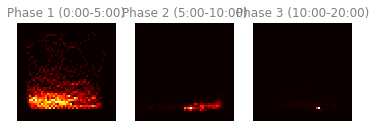

In [19]:
plotter = TrackPlotter(processor)
plotter.plot_heatmap(plot_type='per-phase')